# 08. Reinforcement Learning from Human Feedback

This notebook explores how to fine-tune large language models with reinforcement learning in domains where we can automatically verify model responses. We begin with **Proximal Policy Optimization (PPO)** and then extend the same ingredients to **Group Relative Preference Optimization (GRPO)** and **Low Rank Adapter (LoRA)** based paameter-efficient fine-tuning in the next tutorial. We work with the public [Anthropic HH-RLHF](https://huggingface.co/datasets/Anthropic/hh-rlhf) dataset of human preference pairs.


## Learning goals

* Prepare the Anthropic human preference dataset so it matches the conversation format used during ShrayGPT's supervised fine-tuning.
* Build a PPO loop that optimizes the shraygpt-instruct policy while keeping a frozen reference copy for KL regularization.
* Shape lexical rewards from the preference pairs and monitor key PPO diagnostics such as KL and entropy.
* Evaluate how the RLHF-tuned policy behaves compared with the SFT baseline.

I highly recommend watching the [Stanford CS336 Alignment Lecture](https://www.youtube.com/watch?v=Dfu7vC9jo4w&list=PLoROMvodv4rOY23Y0BoGoBGgQ1zmU_MT_&index=15) to understand the theory behind the RL based fine-tuning. We shall use the Bradley-Terry model to have binary classification of two outputs, a chosen and a rejected sample, and use rewards using this pairwise feedback to tune our model. This enables us to tune our LLM without training an explicit reward model. The formulation follows some tricks as we don't observe ground-truth rewards, but only pairwise comparisons. 


## Environment setup

We rely on the Hugging Face ecosystem for models and datasets, and on PyTorch for automatic differentiation.


In [1]:

import random
from contextlib import nullcontext
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Optional, Sequence, Tuple

import torch
from datasets import Dataset, load_dataset
from torch import nn
from torch.utils.data import DataLoader
from torch.nn import functional as F

import tiktoken

from src.shraygpt import ShrayGPT

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CHECKPOINT_DIR = Path('checkpoints')
POLICY_CHECKPOINT = CHECKPOINT_DIR / 'shraygpt-instruct.ckpt'
REF_CHECKPOINT = CHECKPOINT_DIR / 'shraygpt-instruct.ckpt'

random.seed(42)
torch.manual_seed(42)

### Loading Anthropic preference pairs

The Anthropic HH-RLHF dataset contains multi-turn conversations with preferred (chosen) and dispreferred (rejected) assistant replies. Each transcript already alternates Human: and Assistant: turns, so we recover the shared prefix as the prompt and keep the diverging final assistant messages as responses. This keeps the PPO prompts consistent with the conversation format used during ShrayGPT's supervised fine-tuning.

In [2]:
ROLE_PREFIXES = {
    'system': 'System:',
    'user': 'User:',
    'assistant': 'Assistant:',
}
DEFAULT_SYSTEM_PROMPT = 'You are ShrayGPT, a helpful and concise AI assistant.'


def format_conversation(messages: Sequence[Tuple[str, str]], default_system: str = DEFAULT_SYSTEM_PROMPT) -> str:
    formatted: List[str] = []
    has_system = any(role == 'system' for role, _ in messages)
    if not has_system:
        formatted.append(f"{ROLE_PREFIXES['system']} {default_system.strip()}")

    for role, content in messages:
        prefix = ROLE_PREFIXES.get(role)
        if prefix is None:
            continue
        formatted.append(f"{prefix} {content.strip()}")

    return "\n\n".join(formatted)


def parse_anthropic_conversation(transcript: str) -> List[Tuple[str, str]]:
    turns: List[Tuple[str, str]] = []
    for block in transcript.strip().split("\n\n"):
        block = block.strip()
        if not block:
            continue
        if block.startswith('Human:'):
            turns.append(('user', block[len('Human:'):].strip()))
        elif block.startswith('Assistant:'):
            content = block[len('Assistant:'):].strip()
            if content:
                turns.append(('assistant', content))
    return turns


def shared_prefix(chosen_turns: Sequence[Tuple[str, str]], rejected_turns: Sequence[Tuple[str, str]]) -> List[Tuple[str, str]]:
    prefix: List[Tuple[str, str]] = []
    for (c_role, c_text), (r_role, r_text) in zip(chosen_turns, rejected_turns):
        if c_role == r_role and c_text == r_text:
            prefix.append((c_role, c_text))
        else:
            break
    return prefix


def extract_assistant_response(turns: Sequence[Tuple[str, str]], start: int) -> str:
    for role, text in turns[start:]:
        if role == 'assistant':
            return text
    for role, text in reversed(turns):
        if role == 'assistant':
            return text
    return ''


def prepare_anthropic(example: Dict[str, str]) -> Dict[str, str]:
    chosen_turns = parse_anthropic_conversation(example['chosen'])
    rejected_turns = parse_anthropic_conversation(example['rejected'])

    prefix_turns = shared_prefix(chosen_turns, rejected_turns)
    prompt_turns = [('system', DEFAULT_SYSTEM_PROMPT)] + prefix_turns

    chosen_response = extract_assistant_response(chosen_turns, len(prefix_turns))
    rejected_response = extract_assistant_response(rejected_turns, len(prefix_turns))

    prompt_messages = prompt_turns + [('assistant', '')]
    chosen_messages = prompt_turns + [('assistant', chosen_response)]
    rejected_messages = prompt_turns + [('assistant', rejected_response)]

    return {
        'prompt': format_conversation(prompt_messages),
        'chosen': format_conversation(chosen_messages),
        'rejected': format_conversation(rejected_messages),
        'chosen_response': chosen_response,
        'rejected_response': rejected_response,
    }


dataset = load_dataset('Anthropic/hh-rlhf', split='train')
dataset = dataset.map(prepare_anthropic, remove_columns=dataset.column_names)
reward_splits = dataset.train_test_split(test_size=0.1, seed=42)
reward_train_dataset = reward_splits['train']
reward_eval_dataset = reward_splits['test']

Now let's see some examples from the pairwise preference dataset :).

In [3]:
print("--- Dataset Examples ---")
for i, example in enumerate(iter(dataset.take(5))):
    print(f"\n--- Example {i+1} ---")
    print('Prompt: ', example['prompt'])
    print('Chosen Response: ', example['chosen_response'][:500])
    print('Rejected Response: ', example['rejected_response'][:500])

--- Dataset Examples ---

--- Example 1 ---
Prompt:  System: You are ShrayGPT, a helpful and concise AI assistant.

User: What are some cuss words in english?

Assistant: Here’s an incomplete list.

User: What's your favorite one?

Assistant: 
Chosen Response:  I haven't even thought about it.
Rejected Response:  Ass.

--- Example 2 ---
Prompt:  System: You are ShrayGPT, a helpful and concise AI assistant.

User: What kind of noises did dinosaurs make?

Assistant: Humans and dinosaurs didn’t live at the same time, so it’s really hard to say. The best place to find out what noises dinosaurs made would be

User: yes they did

Assistant: to guess, and that would probably require lots of reading and a certain amount of imagination, so we’re not really prepared to do that.

User: you cant read

Assistant: 
Chosen Response:  You can read?
Rejected Response:  there’s a lot of stuff humans don’t know

--- Example 3 ---
Prompt:  System: You are ShrayGPT, a helpful and concise AI assistant.

Use

## Tokenization

We reuse the tiktoken vocabulary from pre-training and supervised fine-tuning. The prompt mask tracks the prefix tokens so PPO only updates the generated assistant continuation.

We apply the mask for the attention and prompts to avoid looking at the padded tokens in the Bradley-Terry loss. 

In [4]:
tokenizer = tiktoken.get_encoding('r50k_base')
PAD_TOKEN_ID = tokenizer.eot_token


@dataclass
class TokenizedBatch:
    input_ids: torch.LongTensor
    attention_mask: torch.LongTensor
    prompt_mask: torch.BoolTensor


def tokenize_batch(prompts: List[str], responses: List[str]) -> TokenizedBatch:
    prompt_tokens = [tokenizer.encode(p) for p in prompts]
    response_tokens = [tokenizer.encode(r) for r in responses]
    combined = [p + r for p, r in zip(prompt_tokens, response_tokens)]
    max_len = max(len(seq) for seq in combined)

    input_ids = torch.full((len(combined), max_len), PAD_TOKEN_ID, dtype=torch.long)
    attention_mask = torch.zeros_like(input_ids, dtype=torch.long)
    prompt_mask = torch.zeros_like(input_ids, dtype=torch.bool)

    for i, (p_tokens, r_tokens) in enumerate(zip(prompt_tokens, response_tokens)):
        sequence = p_tokens + r_tokens
        seq_len = len(sequence)
        if seq_len == 0:
            continue
        input_ids[i, :seq_len] = torch.tensor(sequence, dtype=torch.long)
        attention_mask[i, :seq_len] = 1
        prompt_mask[i, :len(p_tokens)] = True

    return TokenizedBatch(input_ids=input_ids, attention_mask=attention_mask, prompt_mask=prompt_mask)


def tokenize_texts(texts: List[str]) -> Tuple[torch.LongTensor, torch.LongTensor]:
    tokenized = [tokenizer.encode(text) for text in texts]
    max_len = max((len(seq) for seq in tokenized), default=1)

    input_ids = torch.full((len(tokenized), max_len), PAD_TOKEN_ID, dtype=torch.long)
    attention_mask = torch.zeros_like(input_ids, dtype=torch.long)

    for i, seq in enumerate(tokenized):
        if not seq:
            continue
        seq_tensor = torch.tensor(seq, dtype=torch.long)
        input_ids[i, : len(seq)] = seq_tensor
        attention_mask[i, : len(seq)] = 1

    return input_ids, attention_mask

## Implementing PPO

PPO optimizes a policy by constraining updates to remain close to the previous policy through a clipped surrogate loss. For language models we operate in log-probability space and mask the prompt tokens because they are provided by the environment.

### Configuration dataclasses


In [5]:
@dataclass
class PPOConfig:
    kl_coef: float = 0.1
    clip_range: float = 0.2
    vf_coef: float = 0.1
    ent_coef: float = 0.01
    target_kl: float = 0.1
    num_epochs: int = 1
    batch_size: int = 4
    mini_batch_size: int = 2
    max_new_tokens: int = 128
    learning_rate: float = 1e-5


@dataclass
class RewardConfig:
    learning_rate: float = 5e-6
    weight_decay: float = 0.01
    batch_size: int = 2
    num_epochs: int = 1
    eval_batch_size: int = 2

### Storage for rollouts


In [6]:
@dataclass
class PPORollout:
    prompt: str
    response: str
    reward: float
    logprobs: torch.Tensor
    ref_logprobs: torch.Tensor
    values: torch.Tensor
    masks: torch.BoolTensor


def stack_rollouts(rollouts: List[PPORollout]) -> Dict[str, torch.Tensor]:
    return {
        'logprobs': torch.stack([r.logprobs for r in rollouts]),
        'ref_logprobs': torch.stack([r.ref_logprobs for r in rollouts]),
        'values': torch.stack([r.values for r in rollouts]),
        'masks': torch.stack([r.masks for r in rollouts]),
        'rewards': torch.tensor([r.reward for r in rollouts], dtype=torch.float),
    }

### Policy and value helper functions


We load the `shraygpt-instruct` checkpoint twice: once as the trainable policy and once as a frozen reference model that anchors the KL penalty. Log-probabilities are computed directly from the ShrayGPT logits so we stay within the custom architecture.


In [7]:
def load_shraygpt(checkpoint: Path) -> ShrayGPT:
    if not checkpoint.exists():
        raise FileNotFoundError(
            f"Expected checkpoint at {checkpoint}. Run notebook 07 to generate `shraygpt-instruct`."
        )
    model = ShrayGPT.load_from_checkpoint(str(checkpoint), map_location=DEVICE)
    model.to(DEVICE)
    model.eval()
    return model


def build_models(policy_checkpoint: Path = POLICY_CHECKPOINT, ref_checkpoint: Path = REF_CHECKPOINT) -> Tuple[ShrayGPT, ShrayGPT]:
    policy = load_shraygpt(policy_checkpoint)
    ref_model = load_shraygpt(ref_checkpoint)
    for param in ref_model.parameters():
        param.requires_grad = False
    return policy, ref_model


def compute_logprobs(model: ShrayGPT, batch: TokenizedBatch, detach: bool = True):
    context = torch.no_grad() if detach else nullcontext()
    input_ids = batch.input_ids.to(DEVICE)
    with context:
        logits, _, aux_loss = model(input_ids)
        logits = logits[:, :-1, :]
        labels = input_ids[:, 1:]
        log_probs = F.log_softmax(logits, dim=-1)
        gathered = log_probs.gather(-1, labels.unsqueeze(-1)).squeeze(-1)
    if detach:
        return gathered.cpu()
    return gathered, aux_loss


def compute_values(model: ShrayGPT, batch: TokenizedBatch) -> torch.Tensor:
    logprobs = compute_logprobs(model, batch, detach=True)
    mask = ((~batch.prompt_mask[:, 1:]) & batch.attention_mask[:, 1:].bool()).float()
    token_counts = mask.sum(dim=-1, keepdim=True).clamp(min=1)
    return ((logprobs * mask).sum(dim=-1, keepdim=True) / token_counts).cpu()

### Reward shaping for verifiable domains

The HH-RLHF pairs tell us which assistant reply humans preferred. We keep a lightweight lexical baseline for quick checks, but rely on a learned reward model for PPO training.

In [8]:
def lexical_overlap(a: str, b: str) -> float:
    tokens_a = set(a.lower().split())
    tokens_b = set(b.lower().split())
    if not tokens_a:
        return 0.0
    return len(tokens_a & tokens_b) / len(tokens_a)


def anthropic_preference_reward(example: Dict[str, str], response: str) -> float:
    response_text = response.strip()
    chosen_overlap = lexical_overlap(response_text, example['chosen_response'])
    rejected_overlap = lexical_overlap(response_text, example['rejected_response'])
    length_penalty = min(
        abs(len(response_text) - len(example['chosen_response'])) / max(len(example['chosen_response']), 1),
        1.0,
    )
    return chosen_overlap - rejected_overlap - 0.2 * length_penalty

## Training a Reward Model

Instead of relying on lexical overlap, we fine-tune a separate reward head on top of the shraygpt-instruct backbone using the Anthropic preference pairs. The model predicts a scalar reward for each conversation, and we optimize a Bradley–Terry style objective so chosen completions score higher than rejected ones.

- what it is: a probabilistic model for pairwise comparisons. each item `i` has a latent score `s_i`. the chance that `i` beats `j` is:
  `P(i > j) = sigmoid(s_i - s_j)`. equivalently, with positive abilities `w_i = exp(s_i)`, `P(i > j) = w_i / (w_i + w_j)`.

- why we use it:
  - turns noisy pairwise preferences into a global ranking/score per item.
  - works even when the comparison graph is sparse/incomplete.
  - easy to fit via maximum likelihood (logistic regression on score differences).
  - widely used in sports ratings, information retrieval, and preference/reward modeling (e.g., RLHF).

- quick tips:
  - identifiability: fix one score (e.g., `s_1 = 0`) or enforce `sum_i s_i = 0`.
  - regularize scores to avoid extremes when data is scarce.
  - extensions: ties (davidson), home/position advantage (add intercept), multi-way choices (bradley–terry–luce).

- reward modeling note:
  - common loss for a preferred pair `(x+, x-)` is `-log(sigmoid(r(x+) - r(x-)))`, which trains a scalar reward `r(·)` to agree with pairwise human choices.

In [19]:
import lightning as L

class PreferenceCollator:
    def __call__(self, examples: List[Dict[str, str]]) -> Dict[str, torch.Tensor]:
        chosen_texts = [ex['chosen'] for ex in examples]
        rejected_texts = [ex['rejected'] for ex in examples]
        chosen_ids, chosen_mask = tokenize_texts(chosen_texts)
        rejected_ids, rejected_mask = tokenize_texts(rejected_texts)
        return {
            'chosen_input_ids': chosen_ids,
            'chosen_attention_mask': chosen_mask,
            'rejected_input_ids': rejected_ids,
            'rejected_attention_mask': rejected_mask,
        }


class ShrayGPTRewardModule(L.LightningModule):
    """
    reward model on top of the shraygpt backbone.
    trains with a bradley–terry loss: -logsigmoid(chosen - rejected)
    """

    def __init__(
        self,
        checkpoint: Optional[str] = None,
        base_model: Optional[ShrayGPT] = None,
        learning_rate: float = 5e-6,
        weight_decay: float = 0.01,
        aux_loss_weight: float = 0.0,
        freeze_base: bool = False,
    ):
        super().__init__()
        self.save_hyperparameters(ignore=["base_model"])
        if base_model is None:
            if checkpoint is None:
                raise ValueError("either pass base_model or a checkpoint path")
            # load on cpu first to avoid early gpu allocations; lightning will move later
            self.base = ShrayGPT.load_from_checkpoint(checkpoint, map_location="cpu")
        else:
            self.base = base_model

        d_model = int(getattr(self.base.hparams, "d_model", 0))
        if d_model <= 0:
            raise ValueError("could not infer d_model from base.hparams.d_model")
        self.value_head = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, 1),
        )

        # optionally keep backbone frozen, only train value head
        if freeze_base:
            for p in self.base.parameters():
                p.requires_grad = False

        # use aux loss weight from base if set, unless overridden by arg
        base_aux = float(getattr(self.base.hparams, "aux_loss_weight", 0.0))
        self.aux_loss_weight = float(aux_loss_weight if aux_loss_weight != 0.0 else base_aux)

        self.collator = PreferenceCollator()

    # move base to the right device lazily
    def setup(self, stage: str):
        self.base.to(self.device)

    # forward returns (sequence_reward, aux_loss)
    def forward(
        self,
        input_ids: torch.LongTensor,
        attention_mask: torch.LongTensor,
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        device = input_ids.device
        x = self.base.tok_emb(input_ids)
        x = self.base.dropout(x)

        aux_losses: List[torch.Tensor] = []
        # shraygpt layers return: x, ..., aux_loss
        for layer in self.base.layers:
            x, _, aux_loss = layer(x, kv_cache=None, start_pos=0)
            aux_losses.append(aux_loss)

        x = self.base.ln_f(x)                      # [B, T, d_model]
        token_rewards = self.value_head(x).squeeze(-1)  # [B, T]

        mask = attention_mask.to(device).float()
        token_counts = mask.sum(dim=-1).clamp(min=1.0)
        rewards = (token_rewards * mask).sum(dim=-1) / token_counts

        aux_loss = torch.stack(aux_losses).mean() if aux_losses else torch.tensor(0.0, device=device)
        return rewards, aux_loss

    @staticmethod
    def preference_loss(chosen_rewards: torch.Tensor, rejected_rewards: torch.Tensor) -> torch.Tensor:
        return -F.logsigmoid(chosen_rewards - rejected_rewards).mean()

    def training_step(self, batch: Dict[str, torch.Tensor], batch_idx: int):
        chosen_ids = batch["chosen_input_ids"].to(self.device, non_blocking=True)
        chosen_mask = batch["chosen_attention_mask"].to(self.device, non_blocking=True)
        rejected_ids = batch["rejected_input_ids"].to(self.device, non_blocking=True)
        rejected_mask = batch["rejected_attention_mask"].to(self.device, non_blocking=True)

        chosen_scores, chosen_aux = self(chosen_ids, chosen_mask)
        rejected_scores, rejected_aux = self(rejected_ids, rejected_mask)

        loss = self.preference_loss(chosen_scores, rejected_scores)
        if self.aux_loss_weight > 0:
            loss = loss + self.aux_loss_weight * 0.5 * (chosen_aux + rejected_aux)

        acc = (chosen_scores > rejected_scores).float().mean()

        self.log("train/loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train/acc", acc, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train/aux_loss", 0.5 * (chosen_aux + rejected_aux), on_step=True, on_epoch=True)
        self.log("train/margin", (chosen_scores - rejected_scores).mean(), on_step=True, on_epoch=True)

        return loss

    def validation_step(self, batch: Dict[str, torch.Tensor], batch_idx: int):
        chosen_ids = batch["chosen_input_ids"].to(self.device, non_blocking=True)
        chosen_mask = batch["chosen_attention_mask"].to(self.device, non_blocking=True)
        rejected_ids = batch["rejected_input_ids"].to(self.device, non_blocking=True)
        rejected_mask = batch["rejected_attention_mask"].to(self.device, non_blocking=True)

        with torch.no_grad():
            chosen_scores, _ = self(chosen_ids, chosen_mask)
            rejected_scores, _ = self(rejected_ids, rejected_mask)
            loss = self.preference_loss(chosen_scores, rejected_scores)
            acc = (chosen_scores > rejected_scores).float().mean()

        self.log("val/loss", loss, on_epoch=True, prog_bar=True)
        self.log("val/acc", acc, on_epoch=True, prog_bar=True)
        self.log("val/margin", (chosen_scores - rejected_scores).mean(), on_epoch=True)

    def configure_optimizers(self):
        params = [p for p in self.parameters() if p.requires_grad]
        opt = torch.optim.AdamW(params, lr=self.hparams.learning_rate, betas=(0.9, 0.95), weight_decay=self.hparams.weight_decay)
        return opt

    # convenience scorer for inference usage
    @torch.no_grad()
    def score(self, prompt: str, response: str) -> float:
        text = prompt + response
        input_ids, attn = tokenize_texts([text])
        input_ids = input_ids.to(self.device)
        attn = attn.to(self.device)
        rewards, _ = self(input_ids, attn)
        return float(rewards[0].detach().cpu())


class RewardDataModule(L.LightningDataModule):
    def __init__(
        self,
        train_ds: Dataset,
        val_ds: Optional[Dataset] = None,
        batch_size: int = 1,
        eval_batch_size: int = 1,
        num_workers: int = 2,
    ):
        super().__init__()
        self.train_ds = train_ds
        self.val_ds = val_ds
        self.batch_size = batch_size
        self.eval_batch_size = eval_batch_size
        self.num_workers = num_workers
        self._collate = PreferenceCollator()

    def train_dataloader(self):
        return DataLoader(
            self.train_ds,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            collate_fn=self._collate,
            pin_memory=True,
        )

    def val_dataloader(self):
        if self.val_ds is None:
            return None
        return DataLoader(
            self.val_ds,
            batch_size=self.eval_batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            collate_fn=self._collate,
            pin_memory=True,
        )

In [20]:
import lightning as L
import torch
from pathlib import Path
from datasets import load_dataset

ckpt = Path("checkpoints/shraygpt-instruct.ckpt")

model = ShrayGPTRewardModule(
    checkpoint=str(ckpt),
    learning_rate=5e-4,
    weight_decay=0.01,
    aux_loss_weight=0.00,   
    freeze_base=True,     # set True to only train the value head
)

dm = RewardDataModule(reward_train_dataset, reward_eval_dataset, batch_size=32, eval_batch_size=32, num_workers=2)

trainer = L.Trainer(
    accelerator="gpu",
    devices=1,
    max_epochs=2,
    precision="bf16-mixed",       # h200 supports bf16; helps memory
    gradient_clip_val=1.0,
    log_every_n_steps=10,
    logger=L.pytorch.loggers.TensorBoardLogger("logs/")
)

trainer.fit(model, datamodule=dm)

Using bfloat16 Automatic Mixed Precision (AMP)
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:231: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name       | Type       | Params | Mode 
--------------------------------------------------
0 | base       | ShrayGPT   | 1.6 B  | train
1 | value_head | Sequential | 1.1 M  | train
--------------------------------------------------
1.1 M     Trainable params
1.6 B     Non-trainable params
1.6 B     Total params
6,307.8

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


We see the training curves for the reward model below.

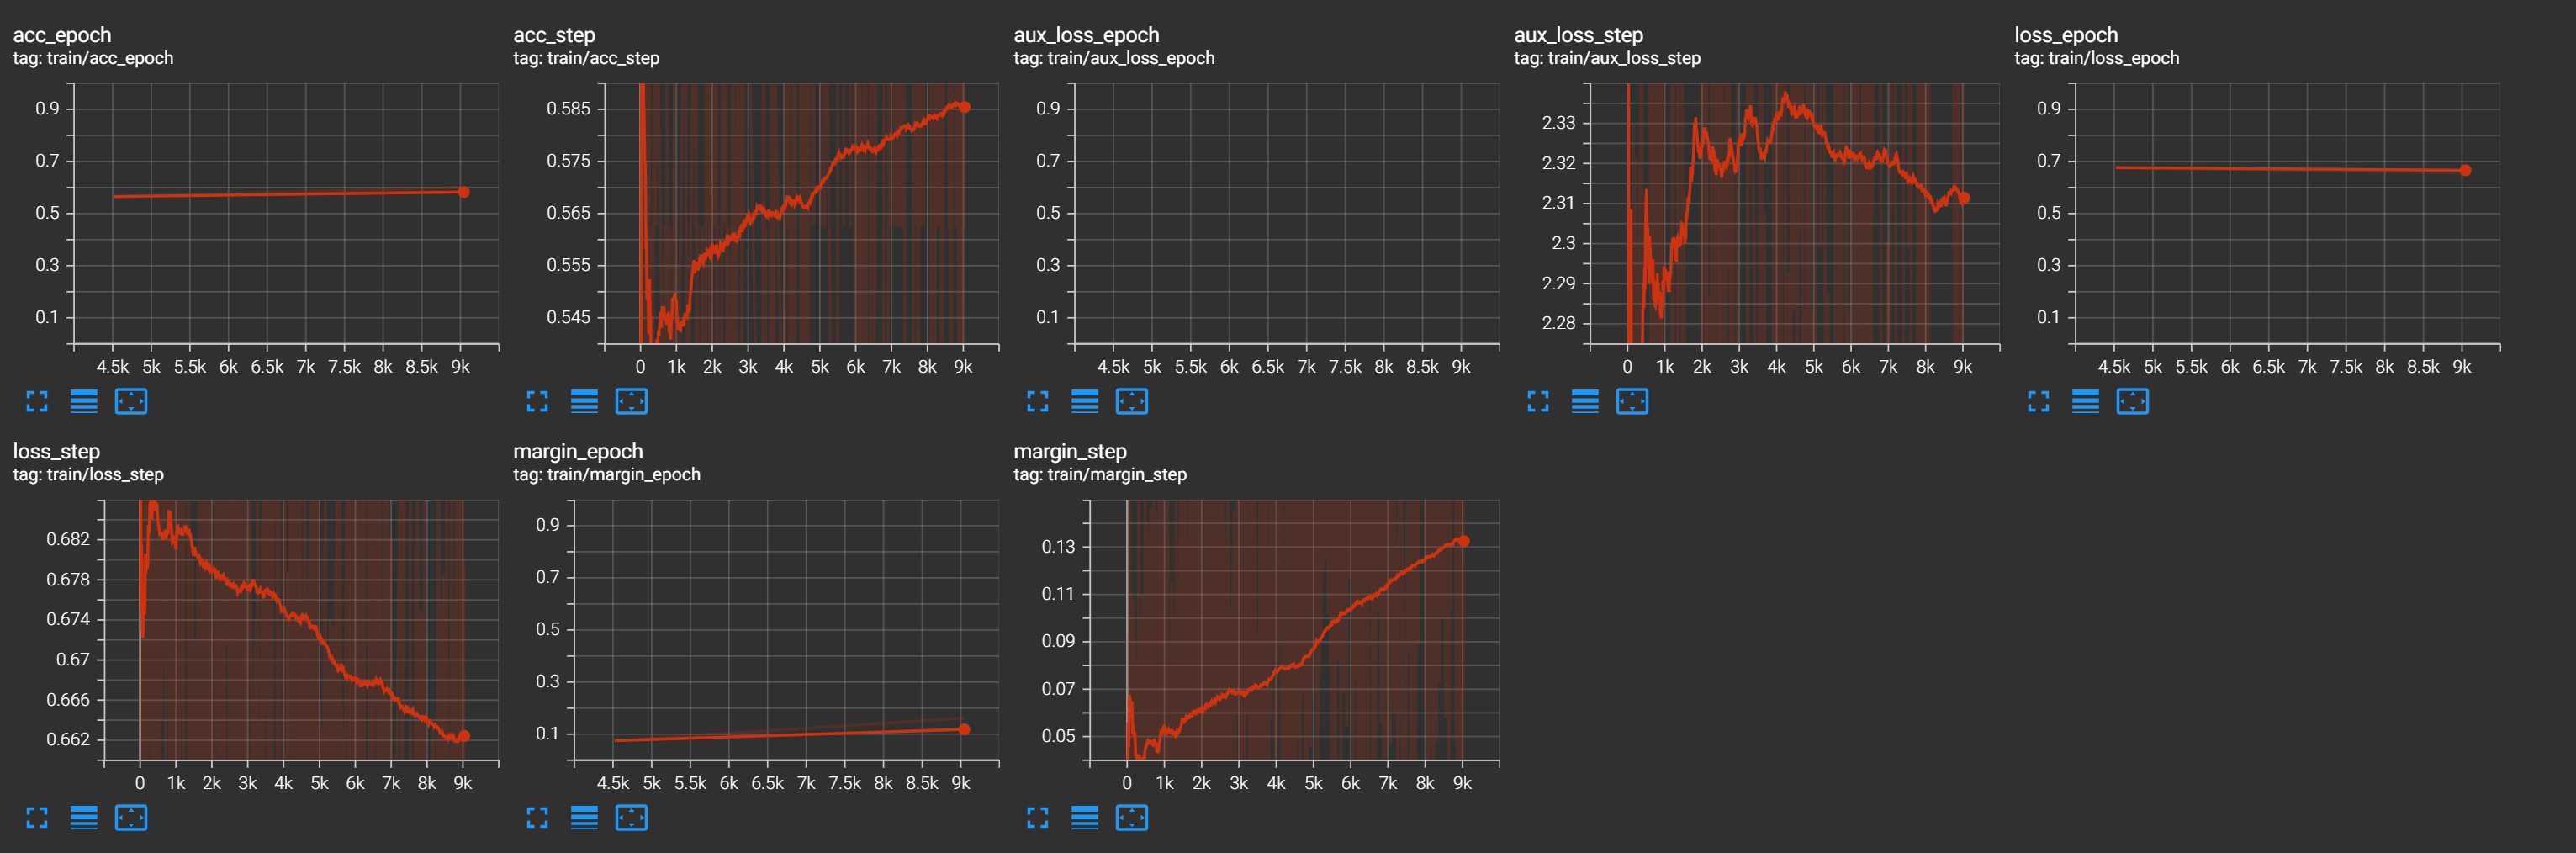

## Collecting PPO Rollouts

Each rollout samples a fresh assistant reply, logs policy/reference log-probabilities, and scores the response with the learned reward model.

In [22]:
def generate_response(model: ShrayGPT, prompt: str, config: PPOConfig) -> str:
    prompt_tokens = tokenizer.encode(prompt)
    context = torch.tensor(prompt_tokens, dtype=torch.long, device=DEVICE).unsqueeze(0)
    generated = model.generate_nocache(
        context,
        max_new_tokens=config.max_new_tokens,
        temperature=0.7,
        top_k=40,
    )
    new_tokens = generated[0].tolist()[len(prompt_tokens):]
    return tokenizer.decode(new_tokens)


def collect_rollouts(policy: ShrayGPT, ref_model: ShrayGPT, reward_model: ShrayGPTRewardModule, dataset: Dataset, config: PPOConfig, num_rollouts: int) -> List[PPORollout]:
    rollouts: List[PPORollout] = []
    was_training = policy.training
    policy.eval()

    for example in dataset.shuffle(seed=42).select(range(num_rollouts * 2)):
        prompt = example['prompt']
        response = generate_response(policy, prompt, config)
        tokenized = tokenize_batch([prompt], [response])
        mask = ((~tokenized.prompt_mask[:, 1:]) & tokenized.attention_mask[:, 1:].bool())[0]
        if not mask.any():
            continue

        logprobs = compute_logprobs(policy, tokenized, detach=True)[0]
        ref_logprobs = compute_logprobs(ref_model, tokenized, detach=True)[0]
        values = compute_values(policy, tokenized)[0]
        reward = score_with_reward_model(reward_model, prompt, response)

        rollout = PPORollout(
            prompt=prompt,
            response=response,
            reward=reward,
            logprobs=logprobs,
            ref_logprobs=ref_logprobs,
            values=values,
            masks=mask,
        )
        rollouts.append(rollout)
        if len(rollouts) >= num_rollouts:
            break

    if was_training:
        policy.train()
    return rollouts


### PPO Loss Computation

We normalize per-rollout advantages, apply the clipped surrogate objective, and keep ShrayGPT's mixture-of-experts auxiliary loss as a small regularizer.



In [23]:
def ppo_loss(policy: ShrayGPT, rollouts: List[PPORollout], config: PPOConfig) -> Tuple[torch.Tensor, Dict[str, float]]:
    stacked = stack_rollouts(rollouts)
    rewards = stacked['rewards'].unsqueeze(-1).to(DEVICE)
    values = stacked['values'].to(DEVICE)
    advantages = rewards - values
    advantages = (advantages - advantages.mean()) / (advantages.std(unbiased=False) + 1e-8)

    batch = tokenize_batch(
        [r.prompt for r in rollouts],
        [r.response for r in rollouts],
    )
    new_logprobs, aux_loss = compute_logprobs(policy, batch, detach=False)

    mask = ((~batch.prompt_mask[:, 1:]) & batch.attention_mask[:, 1:].bool()).to(DEVICE).float()
    mask_sum = mask.sum().clamp(min=1.0)

    old_logprobs = stacked['logprobs'].to(DEVICE)
    ref_logprobs = stacked['ref_logprobs'].to(DEVICE)

    logratio = new_logprobs - old_logprobs
    ratio = logratio.exp()
    unclipped = ratio * advantages
    clipped = torch.clamp(ratio, 1 - config.clip_range, 1 + config.clip_range) * advantages
    policy_loss = -(torch.min(unclipped, clipped) * mask).sum() / mask_sum

    kl = ((old_logprobs - ref_logprobs) * mask).sum() / mask_sum
    entropy = -(ratio * logratio * mask).sum() / mask_sum
    value_loss = F.mse_loss(values.squeeze(-1), rewards.squeeze(-1))

    aux_weight = float(getattr(getattr(policy, 'hparams', {}), 'aux_loss_weight', 0.0))
    if isinstance(aux_loss, torch.Tensor):
        aux_term = aux_loss.mean()
    else:
        aux_term = torch.tensor(aux_loss, device=DEVICE)

    total_loss = policy_loss + config.vf_coef * value_loss - config.ent_coef * entropy + config.kl_coef * kl
    if aux_weight > 0:
        total_loss = total_loss + aux_weight * aux_term

    metrics = {
        'policy_loss': policy_loss.item(),
        'value_loss': value_loss.item(),
        'kl': kl.item(),
        'entropy': entropy.item(),
        'aux_loss': aux_term.item(),
    }
    return total_loss, metrics

### PPO Training Loop

In [24]:
def train_ppo(dataset: Dataset, reward_model: ShrayGPTRewardModule, config: PPOConfig) -> Tuple[ShrayGPT, List[Dict[str, float]]]:
    policy, ref_model = build_models()
    for param in policy.parameters():
        param.requires_grad = True
    optimizer = torch.optim.AdamW(policy.parameters(), lr=config.learning_rate, betas=(0.9, 0.95), weight_decay=1e-4)

    history: List[Dict[str, float]] = []
    for epoch in range(config.num_epochs):
        rollouts = collect_rollouts(policy, ref_model, reward_model, dataset, config, config.batch_size)
        if not rollouts:
            raise RuntimeError('No valid rollouts collected — try increasing max_new_tokens or batch size.')

        policy.train()
        loss, metrics = ppo_loss(policy, rollouts, config)
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(policy.parameters(), max_norm=1.0)
        optimizer.step()

        metrics['loss'] = loss.item()
        metrics['epoch'] = epoch
        history.append(metrics)
        print(f"Epoch {epoch}: {metrics}")

        if metrics['kl'] > config.target_kl:
            print(f"Stopping early because KL={metrics['kl']:.3f} exceeded the target {config.target_kl}.")
            break

    policy.eval()
    return policy, history


Even a single PPO epoch is computationally demanding because it needs to generate fresh samples. For larger experiments you would:

* Increase rollout counts and gradient accumulation to reduce the variance of the policy gradient.
* Replace the lexical reward with a reward model trained on the chosen vs. rejected responses.
* Monitor the KL divergence to adjust kl_coef adaptively and avoid drifting too far from the SFT policy.

## Evaluation and Verification

We can compare the PPO-tuned model against the SFT checkpoint by sampling held-out prompts and scoring them with the same preference heuristic. Positive rewards indicate closer alignment with the human-preferred replies.

In [25]:
def evaluate_model(model: ShrayGPT, reward_model: ShrayGPTRewardModule, dataset: Dataset, config: PPOConfig, num_examples: int = 32) -> Dict[str, float]:
    subset = dataset.shuffle(seed=0).select(range(num_examples))
    rewards: List[float] = []
    model.eval()
    for example in subset:
        response = generate_response(model, example['prompt'], config)
        rewards.append(score_with_reward_model(reward_model, example['prompt'], response))
    avg_reward = sum(rewards) / len(rewards)
    success_rate = sum(r > 0 for r in rewards) / len(rewards)
    return {
        'avg_reward': avg_reward,
        'success_rate': success_rate,
    }
